<a href="https://colab.research.google.com/github/tgrappoport/2dmat/blob/master/6_twisted_bilayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twisted bilayers

This notebook has the generators of twisted bilayers. This generator is not discussed in details. For more information, refer to [pybinding documentation](https://docs.pybinding.site/en/stable/index.html)

Installation of pybinding and libraries

In [ ]:
!pip install -i https://test.pypi.org/simple/ pybinding
import math
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt

General definition of twist layers:

In [ ]:
c0 = 0.335  # [nm] graphene interlayer spacing

from scipy.spatial import cKDTree

def twist_layers(theta):
    """Rotate one layer and then a generate hopping between the rotated layers,
       reference is AB stacked"""
    theta = theta / 180 * math.pi  # from degrees to radians

    @pb.site_position_modifier
    def rotate(x, y, z):
        """Rotate layer 2 by the given angle `theta`"""
        layer2 = (z < 0)
        x0 = x[layer2]
        y0 = y[layer2]
        x[layer2] = x0 * math.cos(theta) - y0 * math.sin(theta)
        y[layer2] = y0 * math.cos(theta) + x0 * math.sin(theta)
        return x, y, z

    @pb.hopping_generator('interlayer', energy=0.1)  # eV
    def interlayer_generator(x, y, z):
        """Generate hoppings for site pairs which have distance `d_min < d < d_max`"""
        positions = np.stack([x, y, z], axis=1)
        layer1 = (z == 0)
        layer2 = (z != 0)

        d_min = c0 * 0.98
        d_max = c0 * 1.1
        kdtree1 = cKDTree(positions[layer1])
        kdtree2 = cKDTree(positions[layer2])
        coo = kdtree1.sparse_distance_matrix(kdtree2, d_max, output_type='coo_matrix')

        idx = coo.data > d_min
        abs_idx1 = np.flatnonzero(layer1)
        abs_idx2 = np.flatnonzero(layer2)
        row, col = abs_idx1[coo.row[idx]], abs_idx2[coo.col[idx]]
        return row, col  # lists of site indices to connect

    @pb.hopping_energy_modifier
    def interlayer_hopping_value(energy, x1, y1, z1, x2, y2, z2, hop_id):
        """Set the value of the newly generated hoppings as a function of distance"""
        d = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        interlayer = (hop_id == 'interlayer')
        energy[interlayer] = 0.4 * c0 / d[interlayer]
        return energy

    return rotate, interlayer_generator, interlayer_hopping_value

The first layer is an hBN layer that can be defined as

In [ ]:
def hbn_layer(shape):
    """Generate hBN layer defined by the shape with intralayer hopping terms"""
    from pybinding.repository.graphene.constants import a_cc, t

    a_bn = 56 / 55 * a_cc  # ratio of lattice constants is 56/55

    vn = -1.4  # [eV] nitrogen onsite potential
    vb = 3.34  # [eV] boron onsite potential

    def hbn_monolayer():
        """Create a lattice of monolayer hBN """

        a = math.sqrt(3) * a_bn
        lat = pb.Lattice(a1=[a/2, a/2 * math.sqrt(3)], a2=[-a/2, a/2 * math.sqrt(3)])
        lat.add_sublattices(('Br', [0, -a_bn,   -c0], vb),
                            ('N', [0,     0,   -c0], vn))

        lat.min_neighbors = 2  # no need for hoppings lattice is used only to generate coordinates
        return lat

    model = pb.Model(
        hbn_monolayer(),
        shape
    )

    subs = model.system.sublattices
    idx_b = np.flatnonzero(subs == model.lattice.sublattices["Br"].alias_id)
    idx_n = np.flatnonzero(subs == model.lattice.sublattices["N"].alias_id)
    positions_boron    = model.system[idx_b].positions
    positions_nitrogen = model.system[idx_n].positions

    @pb.site_generator(name='Br', energy=vb)  # onsite energy [eV]
    def add_boron():
        """Add positions of newly generated boron sites"""
        return positions_boron

    @pb.site_generator(name='N', energy=vn)  # onsite energy [eV]
    def add_nitrogen():
        """Add positions of newly generated nitrogen sites"""
        return positions_nitrogen

    @pb.hopping_generator('intralayer_bn', energy=t)
    def intralayer_generator(x, y, z):
        """Generate nearest-neighbor hoppings between B and N sites"""
        positions = np.stack([x, y, z], axis=1)
        layer_bn = (z != 0)

        d_min = a_bn * 0.98
        d_max = a_bn * 1.1
        kdtree1 = cKDTree(positions[layer_bn])
        kdtree2 = cKDTree(positions[layer_bn])
        coo = kdtree1.sparse_distance_matrix(kdtree2, d_max, output_type='coo_matrix')

        idx = coo.data > d_min
        abs_idx = np.flatnonzero(layer_bn)

        row, col = abs_idx[coo.row[idx]], abs_idx[coo.col[idx]]
        return row, col  # lists of site indices to connect

    @pb.hopping_energy_modifier
    def intralayer_hopping_value(energy, x1, y1, z1, x2, y2, z2, hop_id):
        """Set the value of the newly generated hoppings as a function of distance"""
        d = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        intralayer = (hop_id == 'intralayer_bn')
        energy[intralayer] = 0.1 * t * a_bn / d[intralayer]
        return energy

    return add_boron, add_nitrogen, intralayer_generator, intralayer_hopping_value


Finally we call graphene, and superimpose a graphene layer and a hBN layer.

In [ ]:
from pybinding.repository import graphene

shape = pb.circle(radius=2),

model = pb.Model(
    graphene.monolayer_alt(),  # reference stacking is AB (theta=0)
    shape,
    hbn_layer(shape=shape),
    twist_layers(21.787),
)

We can plot the twist structure

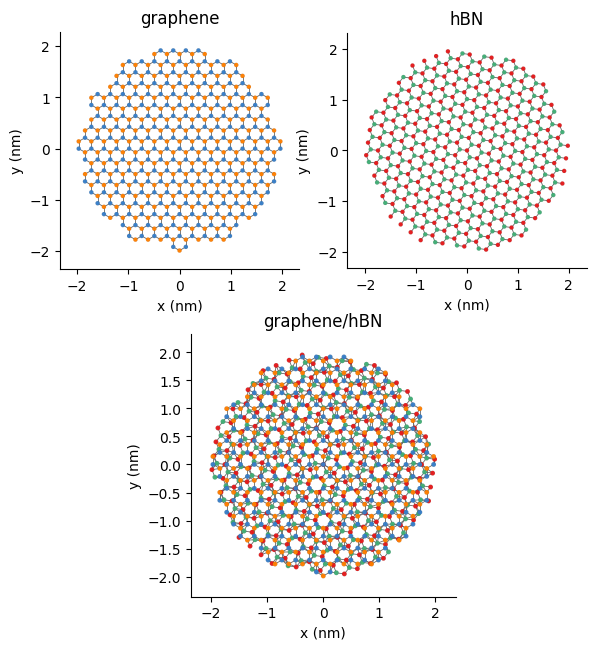

In [ ]:
plt.figure(figsize=(6.8, 7.5))
s = model.system
plt.subplot(2, 2, 1, title="graphene")
s[s.z == 0].plot()
plt.subplot(2, 2, 2, title="hBN")
s[s.z < 0].plot()
plt.subplot(2, 2, (3, 4), title="graphene/hBN")
s.plot()



and also their local density of states for some specific energies

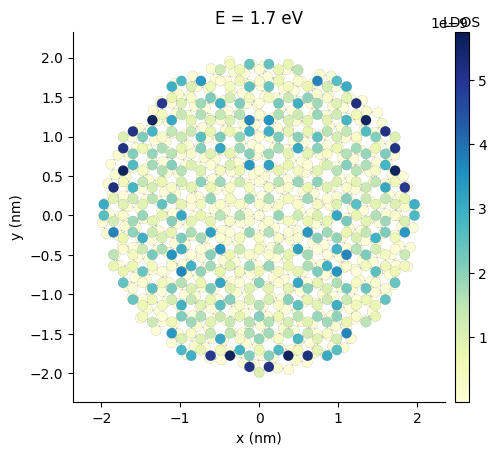

In [ ]:
grid = plt.GridSpec(nrows=1, ncols=1)
for block, energy in zip(grid, [ 1.7]):
    plt.subplot(block)
    plt.title("E = {} eV".format(energy))

    solver = pb.solver.arpack(model, k=200, sigma=0)
    ldos_map = solver.calc_spatial_ldos(energy=energy, broadening=0.05)
    ldos_map.plot()
    pb.pltutils.colorbar(label="LDOS")

plt.show()

In [ ]:
def two_graphene_monolayers():
    """Two individual AB stacked layers of monolayer graphene without any interlayer hopping,"""
    from pybinding.repository.graphene.constants import a_cc, a, t

    lat = pb.Lattice(a1=[a/2, a/2 * math.sqrt(3)], a2=[-a/2, a/2 * math.sqrt(3)])
    lat.add_sublattices(('A1', [0,   a_cc,   0]),
                        ('B1', [0,      0,   0]),
                        ('A2', [0,      0, -c0]),
                        ('B2', [0,  -a_cc, -c0]))
    lat.register_hopping_energies({'gamma0': t})
    lat.add_hoppings(
        # layer 1
        ([0,  0], 'A1', 'B1', 'gamma0'),
        ([0,  1], 'A1', 'B1', 'gamma0'),
        ([1,  0], 'A1', 'B1', 'gamma0'),
        # layer 2
        ([0, 0], 'A2', 'B2', 'gamma0'),
        ([0, 1], 'A2', 'B2', 'gamma0'),
        ([1, 0], 'A2', 'B2', 'gamma0'),
        # not interlayer hopping
    )
    lat.min_neighbors = 2
    return lat

In [ ]:

model = pb.Model(
    two_graphene_monolayers(),
    pb.circle(radius=2.5),
    twist_layers(theta=12.95)

)




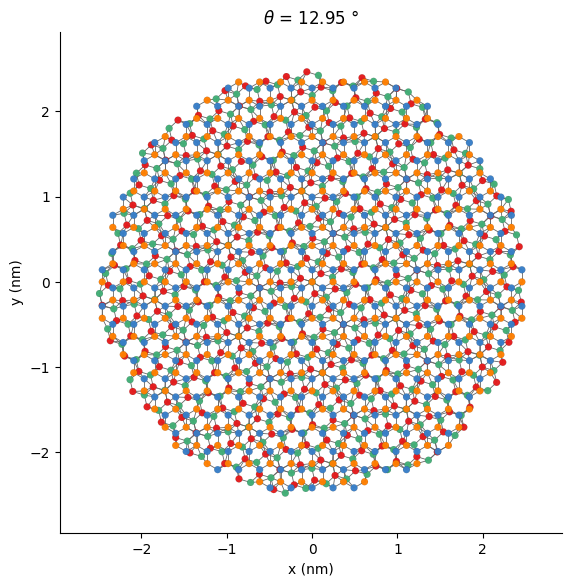

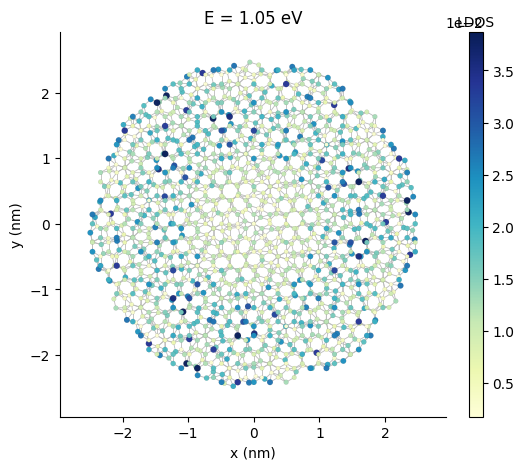

In [ ]:
plt.figure(figsize=(6.5, 6.5))
model.plot()
plt.title(r"$\theta$ = 12.95 $\degree$")
plt.show()
plt.figure(figsize=(15, 5))
grid = plt.GridSpec(nrows=1, ncols=1)
for block, energy in zip(grid, [1.05]):
    plt.subplot(block)
    plt.title("E = {} eV".format(energy))

    solver = pb.solver.arpack(model, k=200, sigma=0)
    ldos_map = solver.calc_spatial_ldos(energy=energy, broadening=0.05)
    ldos_map.plot()
    pb.pltutils.colorbar(label="LDOS")

plt.show()